In [23]:
from mesa import Model, Agent

In [24]:
from mesa import Model, Agent                 # core mesa classes
from mesa.space import NetworkGrid             
from mesa.time import BaseScheduler           
from mesa.datacollection import DataCollector

import networkx as nx                         # for the grid
import numpy as np                            # computations
from matplotlib import pyplot as plt          # visualizing output

In [25]:
G = nx.les_miserables_graph()
G = nx.convert_node_labels_to_integers(G)

In [26]:
class RWModel(Model):

    # model setup
    def __init__(self, G, agent_class, **kwargs):
        
        super().__init__()

        self.schedule = BaseScheduler(self) # time structure
        self.grid     = NetworkGrid(G)          # space structure
        
        # create a single agent who will walk around the graph
        # we haven't defined SWRAgent yet
        # the agent has a name and is associated to the model
        agent = agent_class(self, **kwargs)

        # place the agent at a random node on the graph
        node = self.random.choice(list(G.nodes))
        self.grid.place_agent(agent, node)

        # place the agent into the schedule
        self.schedule.add(agent)

        # data collection. Here we're just going to collect the 
        # current position of each agent
        self.collector = DataCollector(
            agent_reporters = {
                "node" : lambda a: a.pos
            }
        )

    # this is where a timestep actually happens
    # once we've set up the model's __init__() method
    # and the step() method of the agent class, 
    # this is one is usually pretty simple
    def step(self):
        self.schedule.step()
        self.collector.collect(self)

In [27]:
class SRWAgent(Agent):
    def __init__(self, model):
        super().__init__(self, model)
        self.unique_id = "Anakin Graphwalker"

    def step(self):

        # find all possible next steps
        # include_center determines whether or not we count the 
        # current position as a possibility
        options = self.model.grid.get_neighborhood(self.pos, 
                                                include_center = False)

        # pick a random one and go there
        new_node = self.random.choice(options)
        self.model.grid.move_agent(self, new_node)

In [28]:
model = RWModel(G, SRWAgent)

for i in range(100000):
    model.step()

In [29]:
walk_report = model.collector.get_agent_vars_dataframe()
walk_report.head()

,,node
Step,AgentID,
1,Anakin Graphwalker,21
2,Anakin Graphwalker,16
3,Anakin Graphwalker,20
4,Anakin Graphwalker,23
5,Anakin Graphwalker,10


In [30]:
counts = walk_report.groupby("node").size()
freqs = counts / sum(counts)
freqs.head()

node
0    0.00156
1    0.01979
2    0.00599
3    0.00573
4    0.00212
dtype: float64

In [31]:
degs = [G.degree(i) for i in freqs.index]
stationary_dist = degs / np.sum(degs)

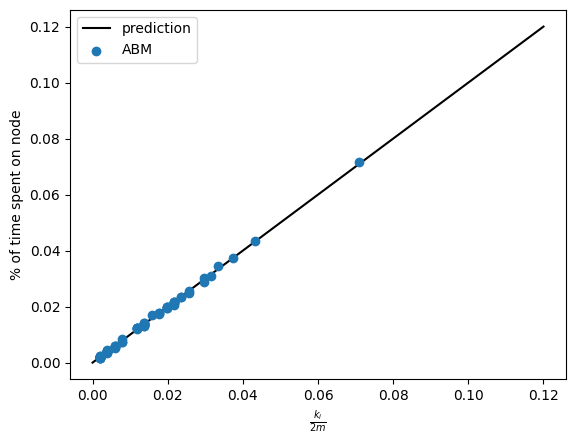

In [32]:
plt.plot([0, .12], 
         [0, .12], 
         color = "black", label = "prediction")

plt.scatter(stationary_dist, 
            freqs, 
            zorder = 100, label = "ABM")

plt.gca().set(xlabel = r"$\frac{k_i}{2m}$", 
              ylabel = "% of time spent on node")

plt.legend()
plt.show()

In [33]:
class PageRankAgent(Agent):

    def __init__(self, model, alpha):
        super().__init__(self, model)
        self.alpha = alpha

    def step(self):
        if np.random.rand() < self.alpha:     # teleport
            options = list(self.model.grid.G.nodes.keys())
        else:                              # standard RW step
            options = self.model.grid.get_neighborhood(self.pos, 
                                                include_center = False)

        # pick a random one and go there
        new_node = self.random.choice(options)
        self.model.grid.move_agent(self, new_node)

In [34]:
pagerank_model = RWModel(G, PageRankAgent, alpha = 0.15)

for i in range(100000):
    pagerank_model.step()

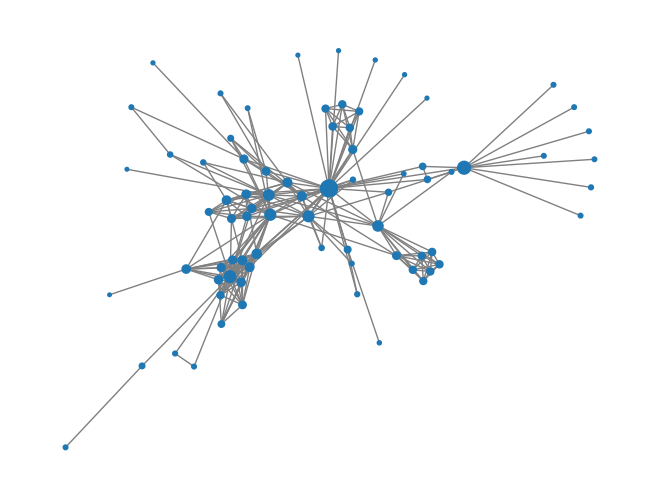

In [35]:
walk_report = pagerank_model.collector.get_agent_vars_dataframe()

counts = walk_report.groupby("node").size()
freqs  = counts / np.sum(counts)

nx.draw(G, 
        node_size = [2000*freqs[i] for i in G.nodes], 
        edge_color = "grey")

## Multi Agent Models

In [36]:
from mesa.time import RandomActivation

class CompartmentalModel(Model):

    # model setup
    def __init__(self, G, agent_class, possible_states = [0,1], state_density = [0.5, 0.5]):

        self.schedule = RandomActivation(self) # time structure
        self.grid = NetworkGrid(G)            # space structure
        
        for node in list(G.nodes):
            state = np.random.choice(possible_states, p = state_density)
            agent = agent_class(node, self, state)
            self.grid.place_agent(agent, node)
            self.schedule.add(agent)

        self.collector = DataCollector(
            agent_reporters = {
                "state" : lambda a: a.state
            }
        )

    def step(self):
        self.schedule.step()
        self.collector.collect(self)

In [37]:
class CompartmentalAgent(Agent):

    def __init__(self, agent_id, model, state):
        super().__init__(agent_id, model)
        self.state = state

    def step(self):
        print(self.pos)
        neighbors = self.model.grid.get_neighbors(self.pos, 
                                                include_center = False)

        # neighbors = self.model.grid.get_cell_list_contents(neighbor_locs)

        adopt_from = np.random.choice(neighbors)

        self.state = adopt_from.state

/Users/theojulien/Library/Python/3.9/lib/python/site-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)
/Users/theojulien/Library/Python/3.9/lib/python/site-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)
/Users/theojulien/Library/Python/3.9/lib/python/site-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)
/Users/theojulien/Library/Python/3.9/lib/python/site-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to

56
36
55
28
29
39
57
27
17
76
15
50
62
32
24
33
8
64
43
0
23
53
19
69
41
67
12
44
14
47
30
68
11
63
13
34
48
22
59
2
38
51
18
74
54
20
65
71
1
66
52
58
46
75
73
21
25
9
70
60
5
3
45
35
37
7
40
10
16
61
49
31
72
42
4
6
26
24
40
50
54
8
16
31
52
67
55
60
0
61
5
75
27
2
63
76
25
38
23
22
4
26
41
68
10
74
72
29
30
20
37
19
13
47
7
17
53
14
35
45
9
51
65
64
43
69
28
15
57
58
62
71
21
32
59
46
73
70
48
36
66
34
33
44
49
18
3
12
42
39
11
1
56
6
35
24
15
44
30
9
59
40
26
58
63
28
25
34
52
56
5
70
66
55
50
45
42
1
31
33
47
61
72
37
41
8
0
6
2
62
75
60
12
19
7
64
4
46
43
68
27
18
71
74
65
14
17
23
32
16
13
48
36
69
20
67
76
21
49
29
38
53
51
39
22
10
57
3
73
54
11
40
25
5
71
45
32
73
11
58
47
62
31
22
17
6
74
35
14
61
7
63
2
50
59
1
72
23
41
69
46
75
13
10
57
68
24
20
0
15
44
38
54
9
27
49
30
52
33
43
48
36
66
21
8
18
55
3
64
70
26
12
56
60
76
65
4
28
39
67
37
51
29
16
34
19
53
42
22
46
66
15
25
40
44
1
67
50
47
18
16
14
19
57
37
54
55
24
72
49
59
31
23
29
69
12
27
58
9
43
34
2
73
21
6
56
75
41


/Users/theojulien/Library/Python/3.9/lib/python/site-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)
/Users/theojulien/Library/Python/3.9/lib/python/site-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)
/Users/theojulien/Library/Python/3.9/lib/python/site-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)
/Users/theojulien/Library/Python/3.9/lib/python/site-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to

49
48
51
54
72
70
62
6
13
14
73
61
53
65
7
22
20
51
36
41
61
37
21
47
7
38
5
0
56
25
64
22
28
10
29
54
58
70
72
46
16
65
34
76
27
42
19
48
62
23
66
55
8
4
44
26
40
20
73
63
13
6
18
49
59
45
67
52
69
14
30
2
60
17
3
71
9
68
39
50
33
12
32
11
43
24
57
35
75
15
1
53
31
74
6
19
38
74
25
56
4
44
14
67
18
73
13
10
8
29
7
31
45
51
11
69
59
27
40
46
76
58
0
66
17
75
65
3
1
72
54
37
26
70
5
68
20
52
50
47
64
35
32
57
15
36
21
43
62
61
39
71
53
24
49
60
34
48
22
33
16
28
30
23
12
63
9
2
41
55
42
62
16
4
63
21
65
33
22
32
45
27
54
48
42
28
34
67
3
19
52
31
6
0
60
58
49
53
56
46
75
76
55
38
37
69
47
15
30
25
20
70
13
1
72
41
61
57
10
7
66
44
18
64
59
9
68
35
12
23
73
11
74
14
24
51
29
8
5
40
36
43
17
26
2
39
50
71
14
76
42
67
44
69
31
22
71
34
36
64
57
27
38
62
19
37
48
55
43
1
17
41
15
63
28
39
51
49
65
7
40
75
18
32
10
59
20
56
46
6
30
61
45
66
21
25
0
8
72
60
2
16
5
50
9
33
26
68
13
54
70
29
11
52
35
4
23
74
58
24
53
73
12
3
47
40
76
73
30
7
50
53
1
52
57
21
38
39
22
31
66
0
43
42
33
65
16
68
1

[Text(0.5, 0, 'Timestep'), Text(0, 0.5, '% of nodes with opinion 1')]

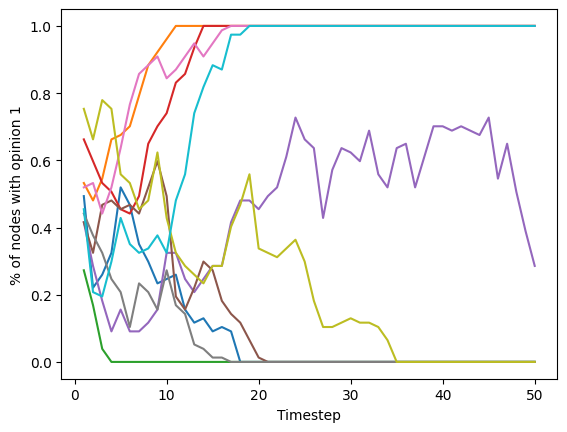

In [38]:
for run in range(10):
    voter_model = CompartmentalModel(G, CompartmentalAgent, [0, 1], [0.5, 0.5])
    for i in range(50):
        voter_model.step()

    report = voter_model.collector.get_agent_vars_dataframe()
    plt.plot(report.groupby("Step").mean())

plt.gca().set(xlabel = "Timestep", ylabel = "% of nodes with opinion 1")